In [ ]:
#  Author: Dr. Daniel Soper
# Purpose: This notebook simulates playing roulette using the Martingale betting system
#          under a variety of different scenarios.
# Outputs: Charts and data describing the relationships among different levels of total
#          profit and the probability of achieving those profit levels.
# License: CC BY 4.0 (https://creativecommons.org/licenses/by/4.0/)

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt, ticker as tick
from zipfile import ZipFile


#define a function that simulates playing roulette using the martingale betting scheme
def play_roulette(minimum_bet, consecutive_losses_until_bust, zeros):
  #validate inputs
  if minimum_bet <= 0:
    raise ValueError('Minimum bet must be greater than zero.')
  if consecutive_losses_until_bust < 1:
    raise ValueError('Number of consecutive losses until bust must be greater than or equal to one.')
  for number_of_zeros_on_wheel in zeros:
    if number_of_zeros_on_wheel < 1 or number_of_zeros_on_wheel > 3:
      raise ValueError('Number of zeros on the roulette wheel must be between one and three.')

  #compute the initial stake required to support the maximum number of consecutive losses
  #before the player busts
  initial_stake = np.sum([minimum_bet * 2**i for i in range(0, consecutive_losses_until_bust)])

  #compute the maximum accumulated profit for which to calculate a probability of occurrence
  maximum_profit_threshold = minimum_bet * 400

  #compute all possible accumulated profit values for which to calculate probabilities of occurrence
  target_profit_thresholds = list(range(minimum_bet, maximum_profit_threshold + 1, minimum_bet))

  #define the number of trials to run. A "trial" is a simulation of playing roulette using the
  #martingale method, with play continuing until the player busts (runs out of money)
  trials = 5000 #increase this number for more accurate decimal precision

  #create a list to hold the collections of numerical results for each number of zeros on the
  #wheel possibility
  all_results = []

  #configure a plot that will be used to depict the numerical results
  fig, ax = plt.subplots(figsize=(16, 9))
  ax.set_xlabel('Total Profit', fontsize=16)
  ax.set_ylabel('Probability of Achieving Profit Before Busting', fontsize=16)
  zero_labels = ['Single-Zero Roulette', 'Double-Zero Roulette', 'Triple-Zero Roulette']
  line_colors = ['green', 'blue', 'red']
  ax.set_title('Martingale Roulette\n\${} Minimum Bet, Bust After {} Consecutive Losses, Initial Stake Required: \${}'.format(minimum_bet, consecutive_losses_until_bust, initial_stake), fontsize=18)
  ax.xaxis.set_ticks(np.arange(0, maximum_profit_threshold + 1, 100))
  ax.xaxis.set_major_formatter(tick.FormatStrFormatter('$%.0f'))
  ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))
  ax.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=1))
  plt.xticks(fontsize=14, rotation=60)
  plt.yticks(fontsize=14)
  plt.grid()

  #for each number of zeros on the wheel possibility
  for number_of_zeros_on_wheel in zeros:
    #create a list to hold the numerical results for the current playing conditions
    results = []

    #initialize counters to record the number of trials in which each profit threshold was acheived
    #prior to busting
    times_target_profits_achieved = np.zeros(len(target_profit_thresholds))

    #for each possible trial
    for trial in range(trials):
      #define a list to hold the player's balance (remaining money) after each spin
      balances = []

      #initialize the current balance and the current bet for this trial
      current_balance = initial_stake
      current_bet = minimum_bet

      #while the player hasn't yet busted (i.e., while the player still has enough money
      #to support the martingale betting scheme)
      while current_bet <= current_balance:
        #get the result of this spin of the roulette wheel.
        #zeros on the wheel are represented by values larger than 36.
        wheel_number = np.random.randint(1, 37 + number_of_zeros_on_wheel)

        #for simplicity, we'll assume that we're betting on "lows" (1 to 18), however
        #any other approximately 50/50 bet would yield identical results (e.g., highs,
        #evens, odds, reds, blacks, etc.)

        #if the player has won on this spin
        if wheel_number <= 18:
          #update the player's current balance to reflect the win and reset the player's
          #bet for the next spin
          current_balance += current_bet
          current_bet = minimum_bet
        else: #if the player lost on this spin
          #update the player's balance to reflect the loss and double their previous
          #bet for the next spin
          current_balance -= current_bet
          current_bet *= 2

        #record the player's balance at the end of this spin
        balances.append(current_balance)

      #process the results of this trial.
      #compute the maximum profit achieved before busting
      maximum_profit_achieved = np.max(balances) - initial_stake

      #for each possible target profit threshold
      for i in range(len(target_profit_thresholds)):
        #if the current profit threshold was achieved during this trial
        if maximum_profit_achieved >= target_profit_thresholds[i]:
          times_target_profits_achieved[i] += 1
        else: #if the current and all subsequent profit targets were not achieved during this trial
          break

    #compute the probability of achieving each target profit threshold before busting
    target_profit_probabilities = times_target_profits_achieved / trials

    #record the results for the current playing conditions
    for i in range(len(target_profit_thresholds)):
      results.append({'minimum_bet': minimum_bet, 'consecutive_losses_until_bust': consecutive_losses_until_bust,
                      'required_initial_stake': initial_stake, 'number_of_zeros_on_wheel': number_of_zeros_on_wheel,
                      'target_profit': target_profit_thresholds[i],
                      'probability_of_achieving_profit_before_busting': target_profit_probabilities[i]})

    #add the the results for the current playing conditions to the collection of overall results
    all_results.append(results)

    #add numerical results for this number of zeros on the wheel possibilit to the plot
    plt.plot(target_profit_thresholds, target_profit_probabilities, linewidth=3,
           color=line_colors[number_of_zeros_on_wheel - 1], label=zero_labels[number_of_zeros_on_wheel - 1])

  plt.legend(fontsize=16)

  #return numerical results and graphical plot for the current playing conditions
  return all_results, plt

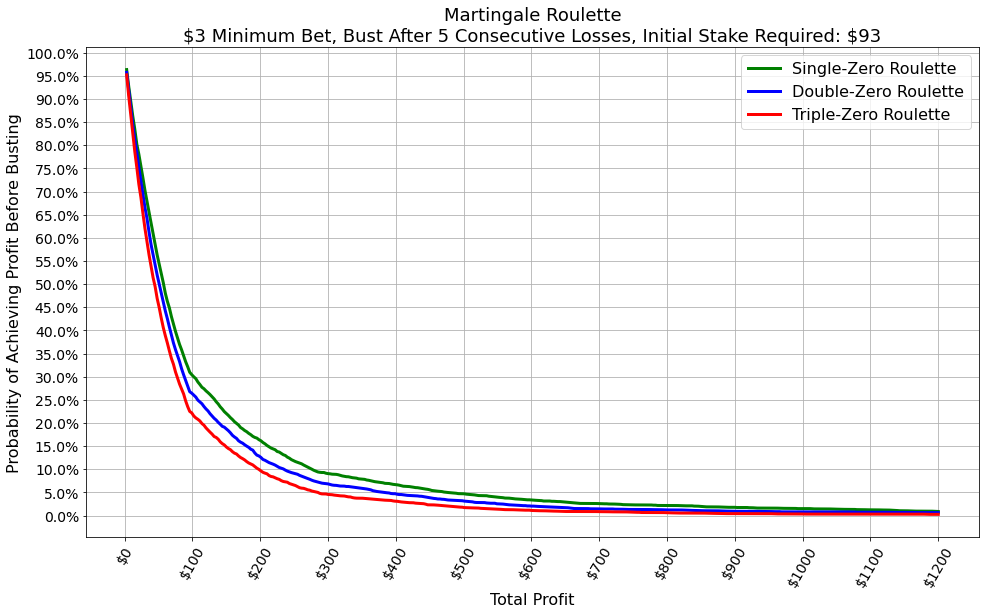

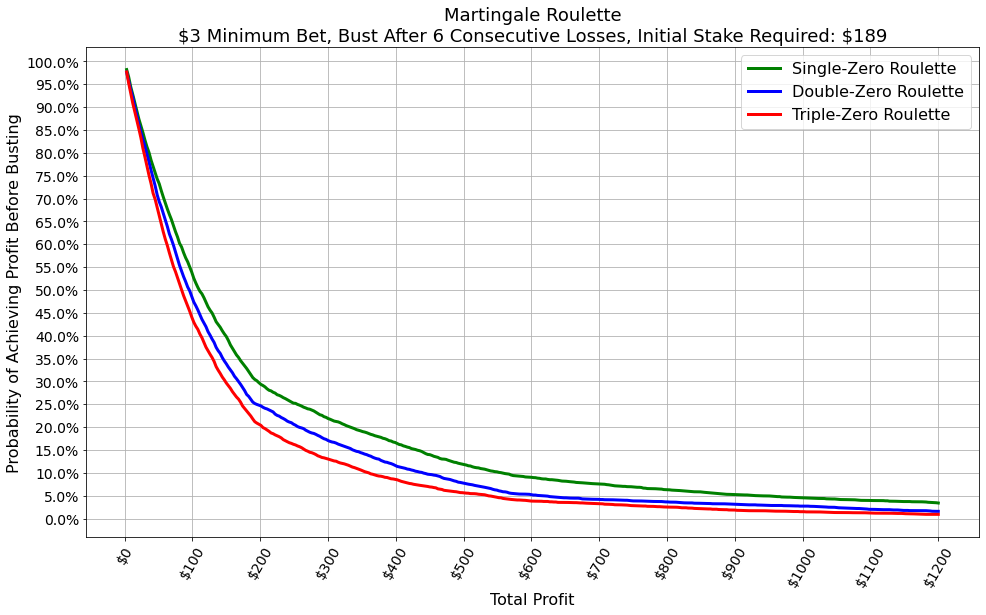

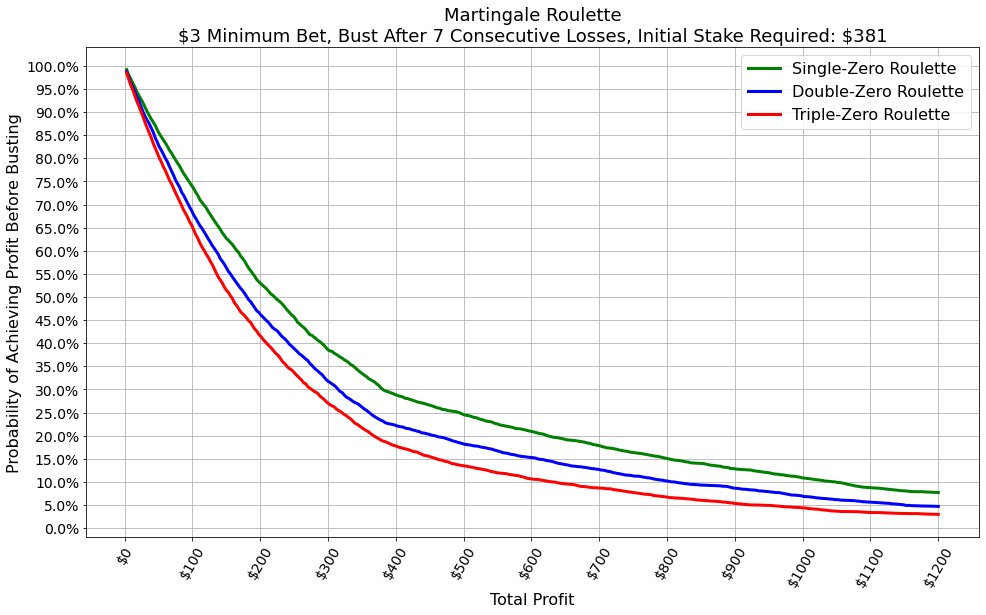

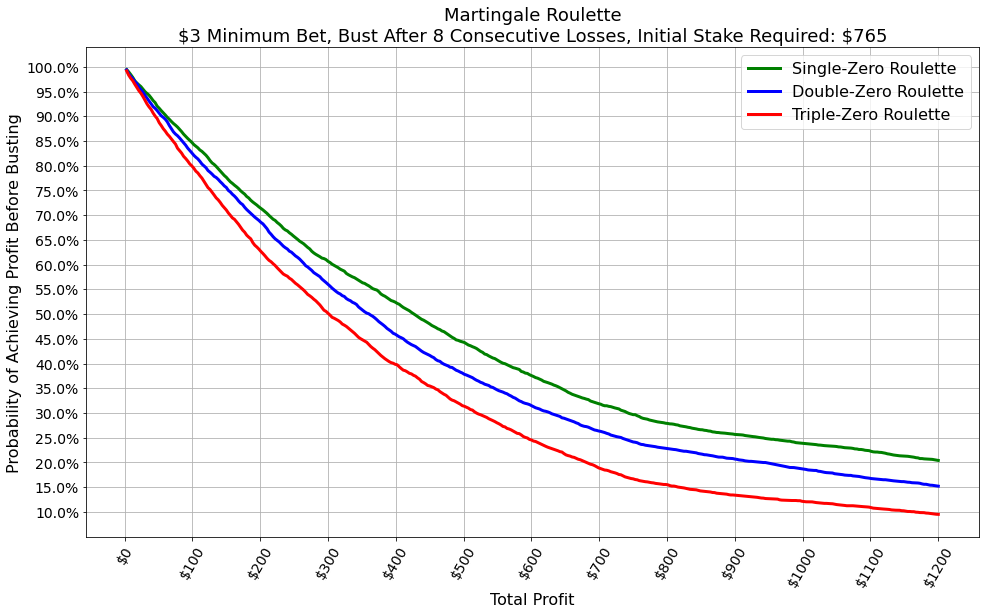

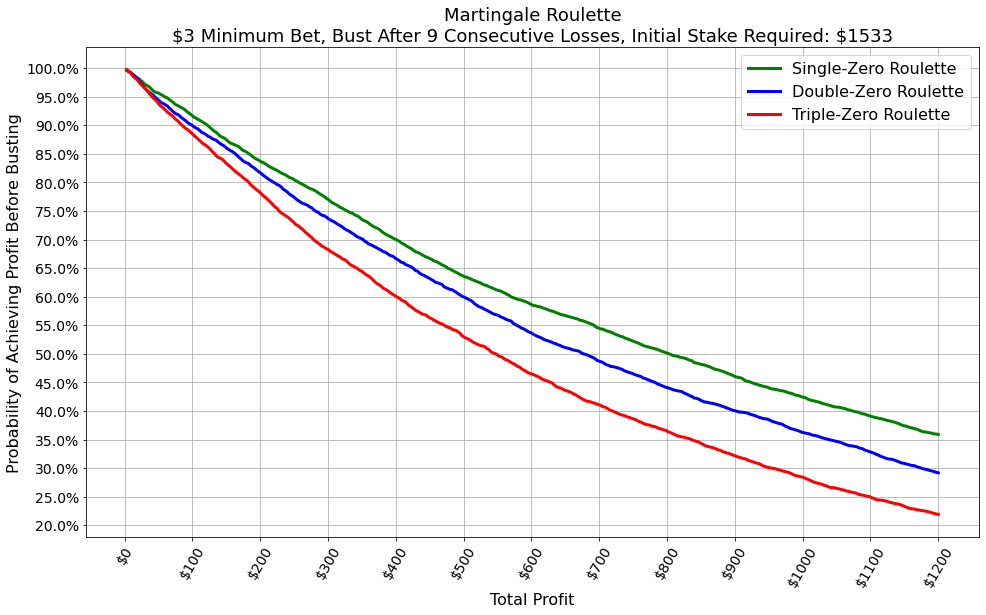

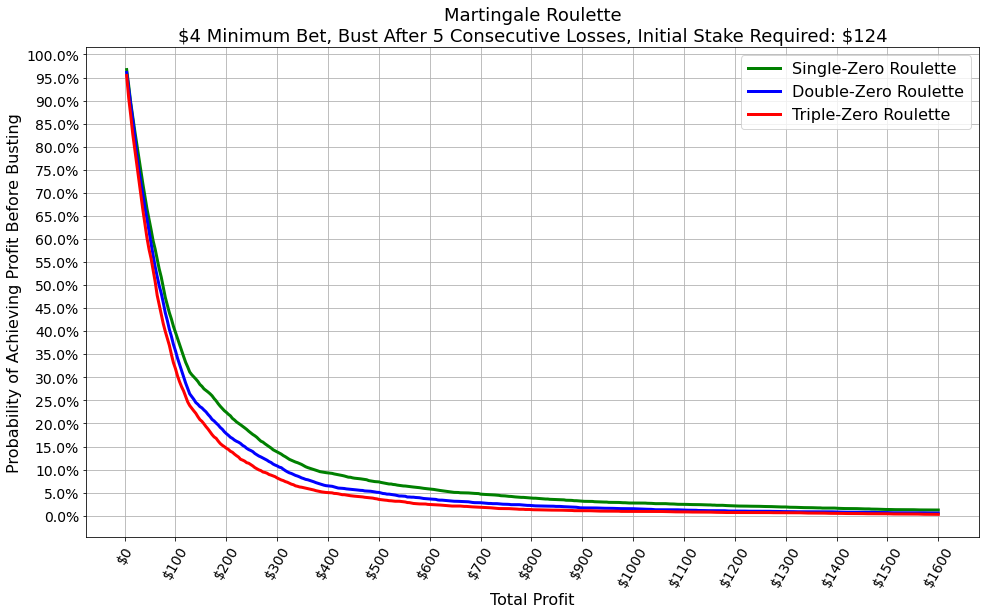

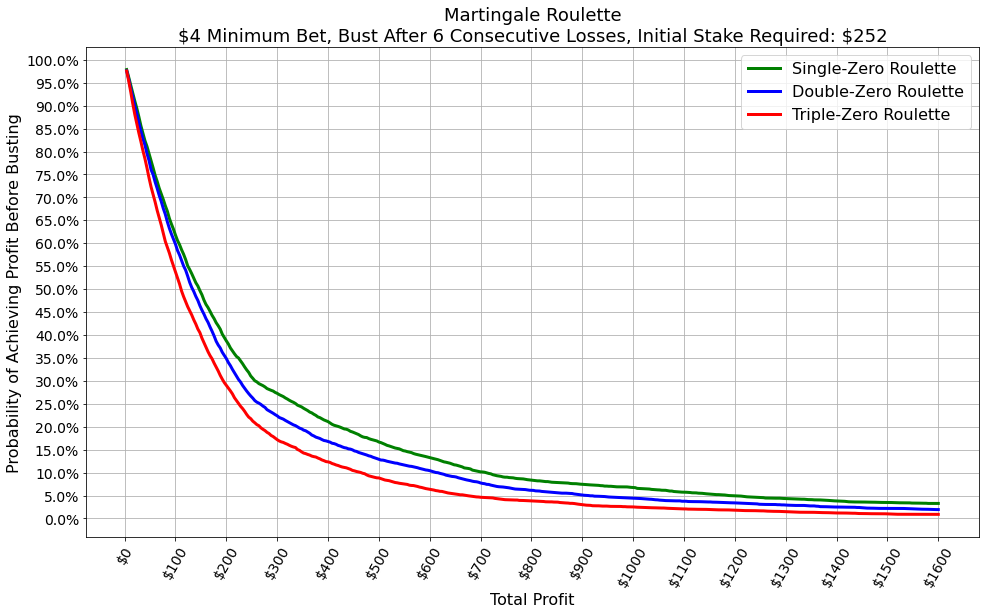

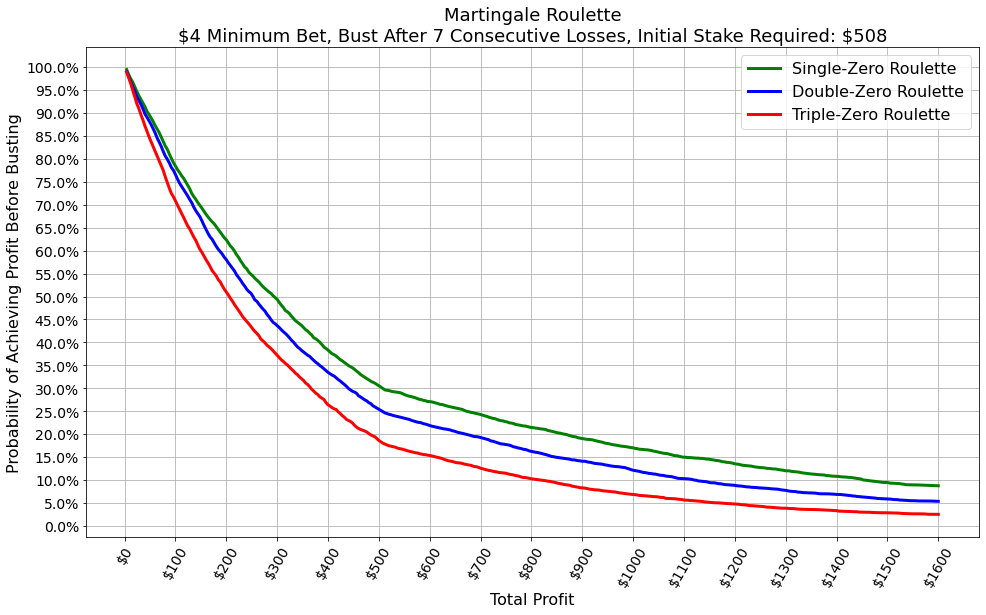

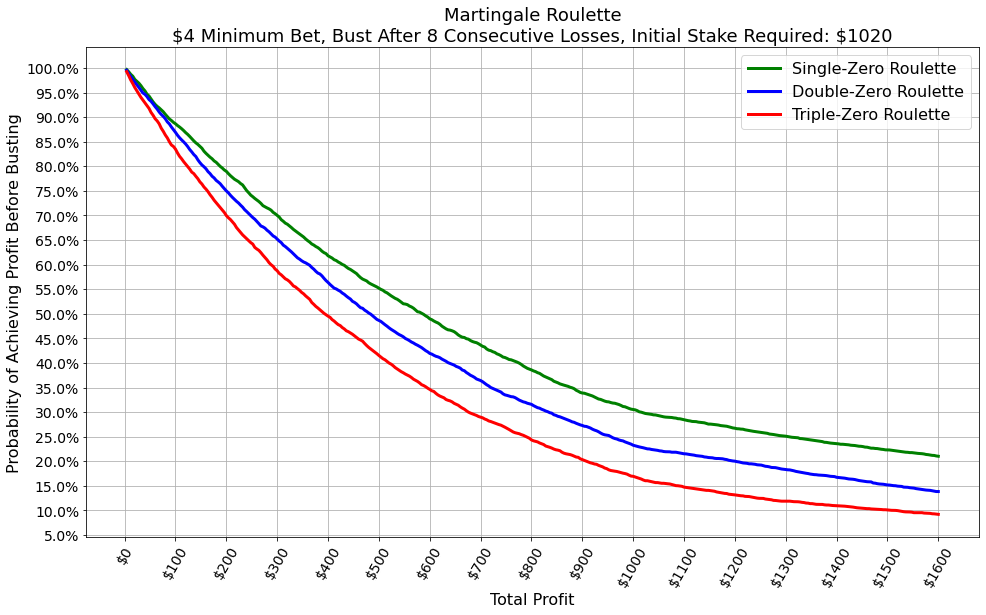

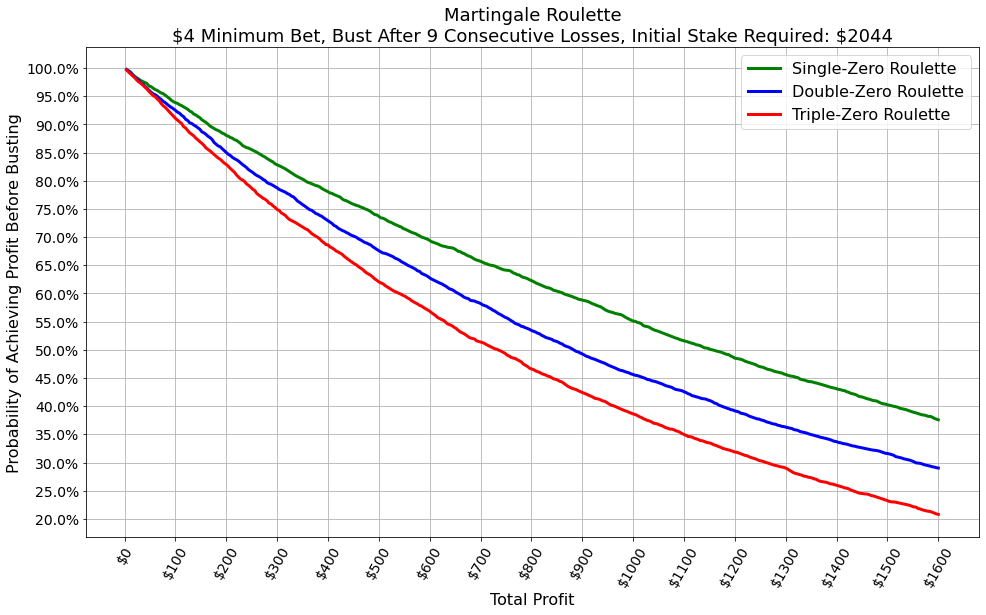

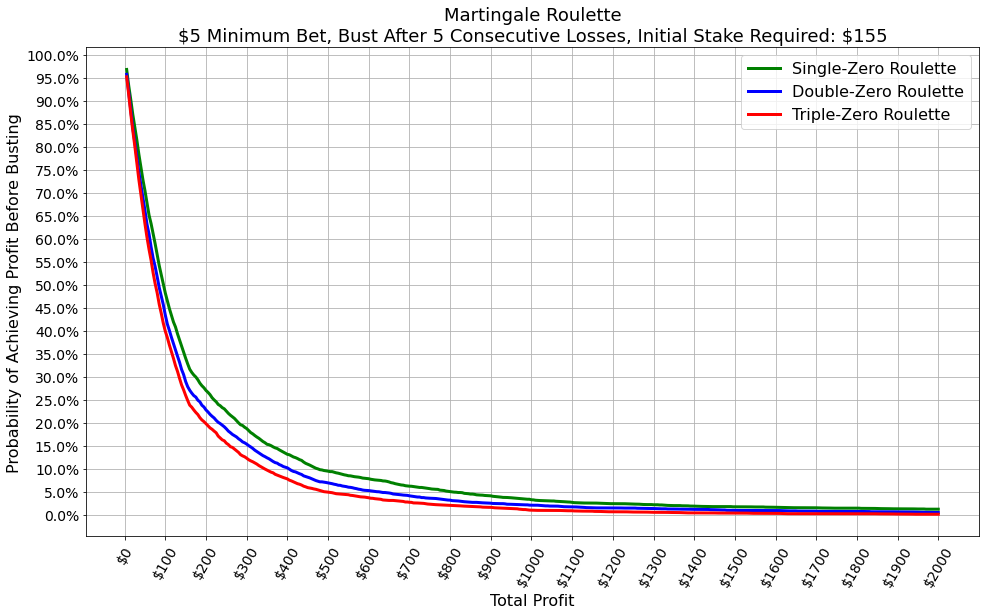

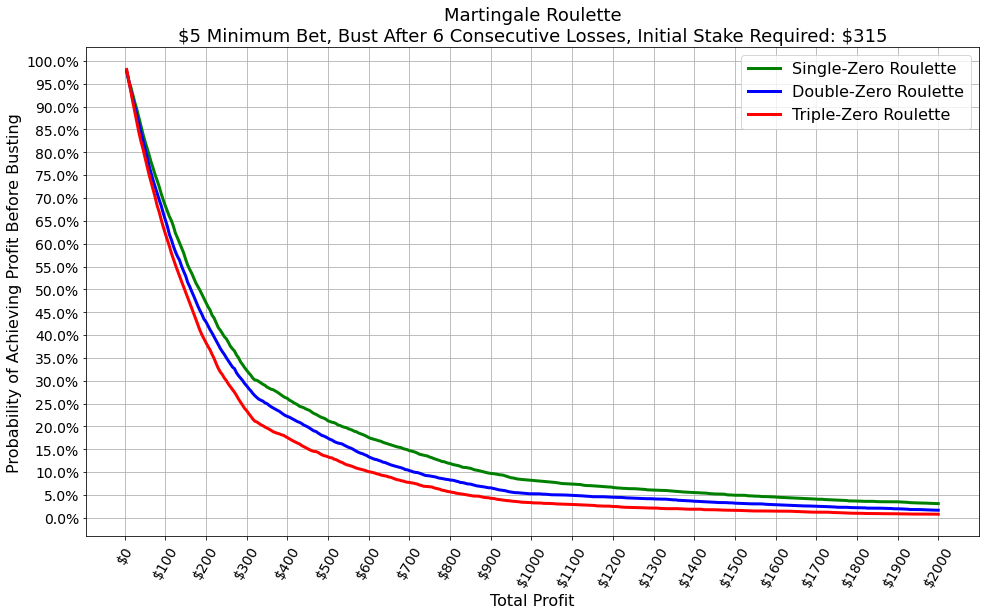

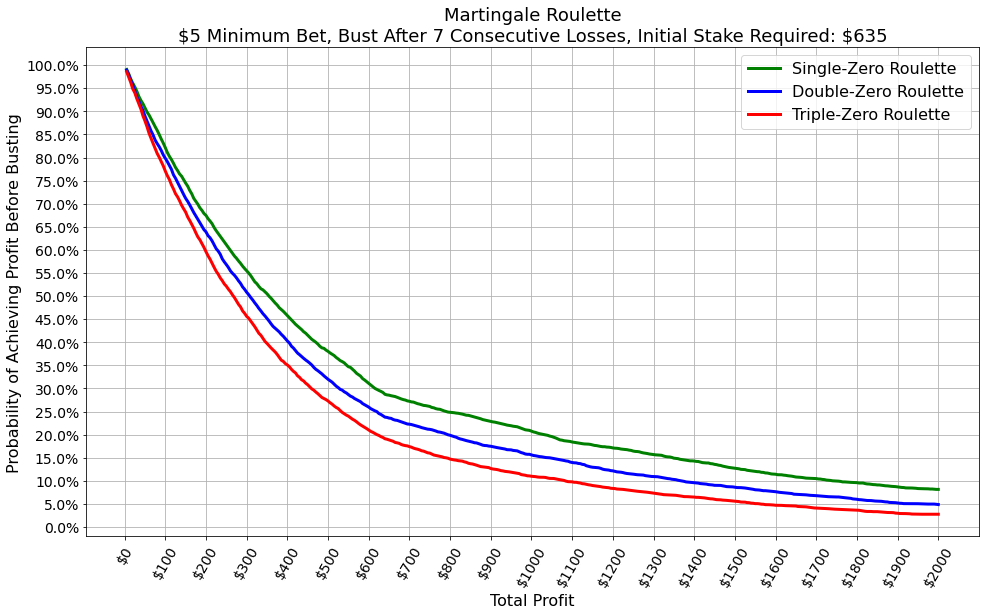

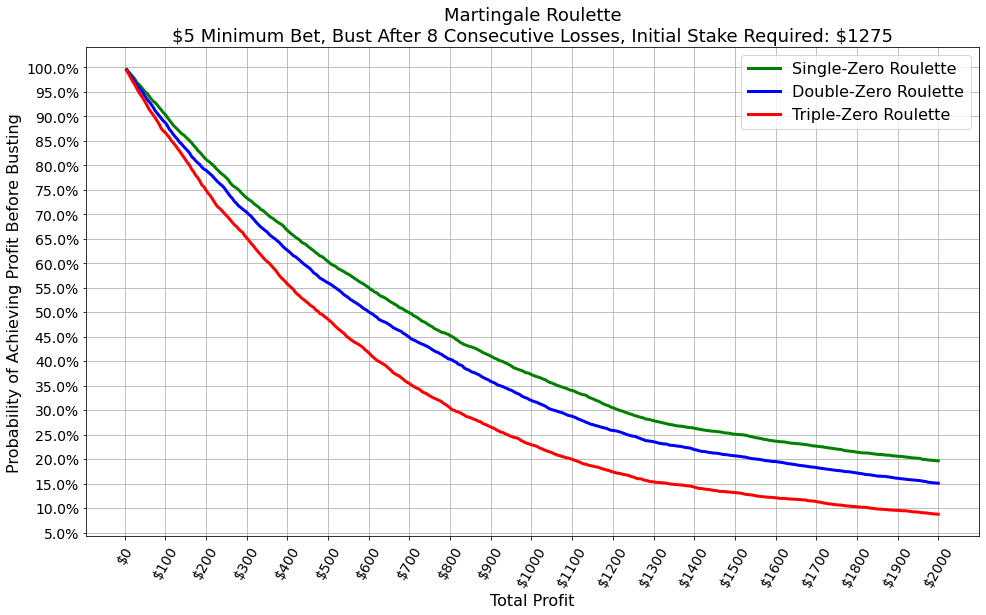

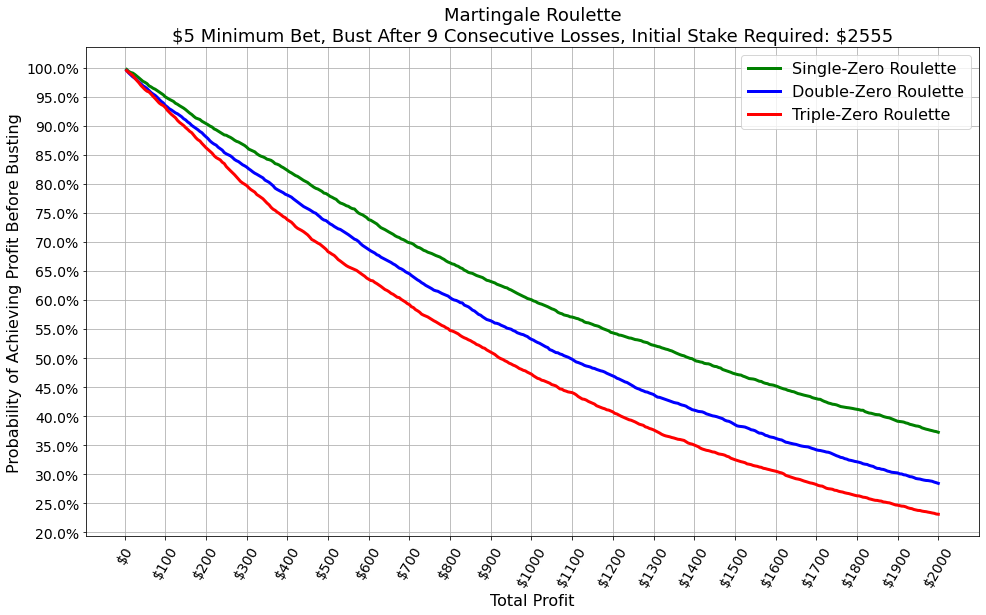

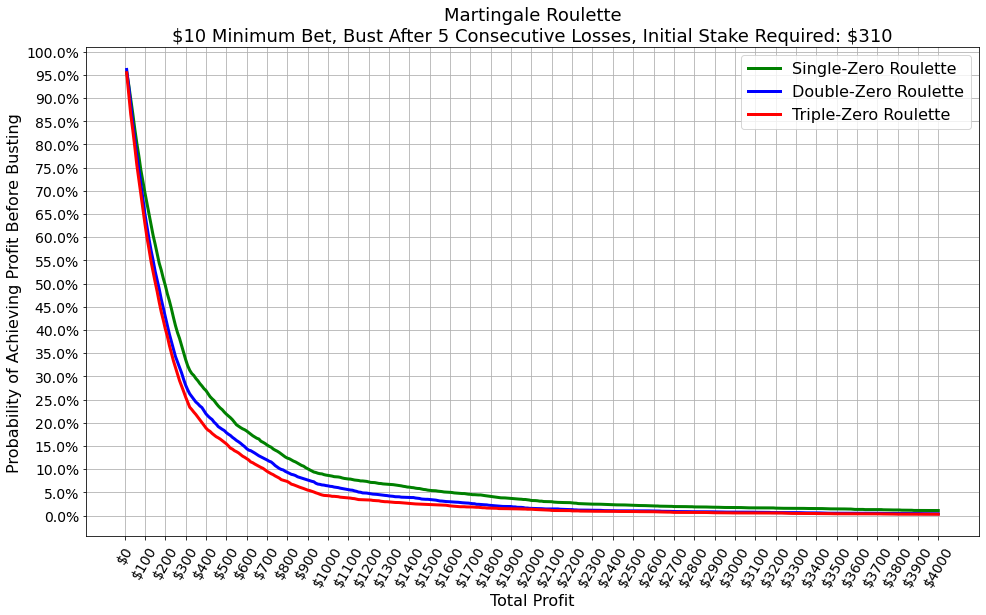

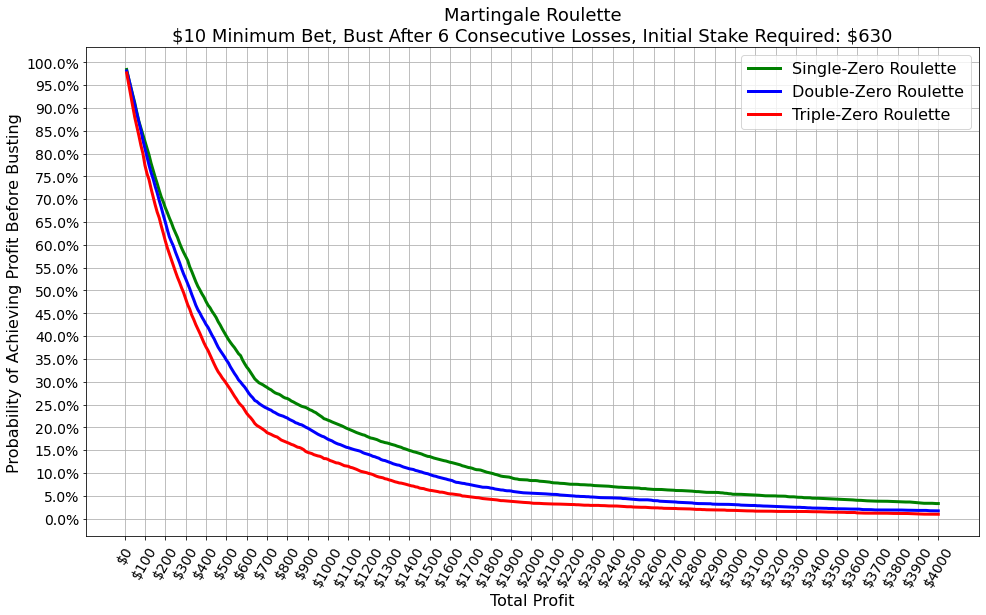

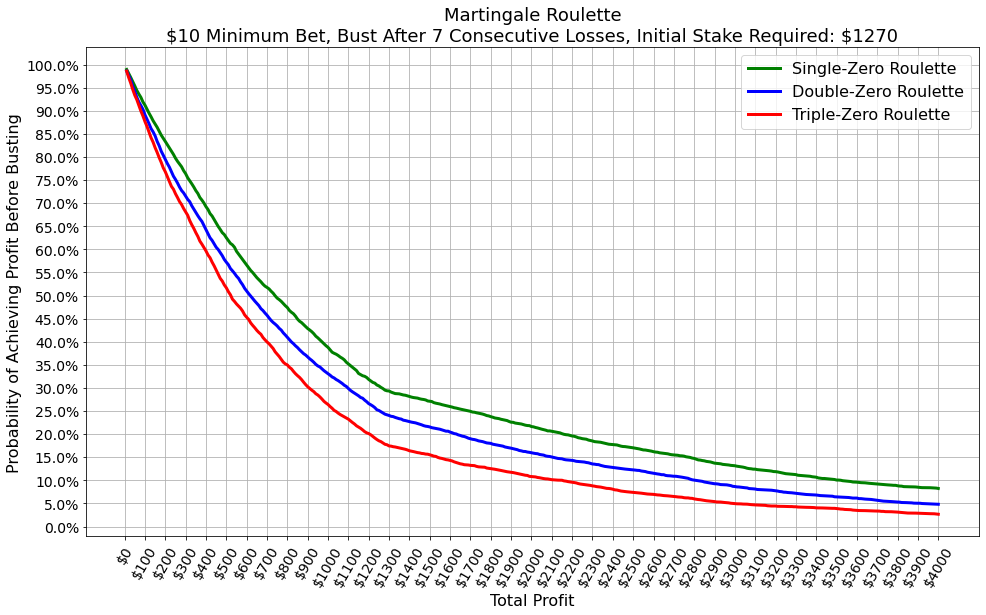

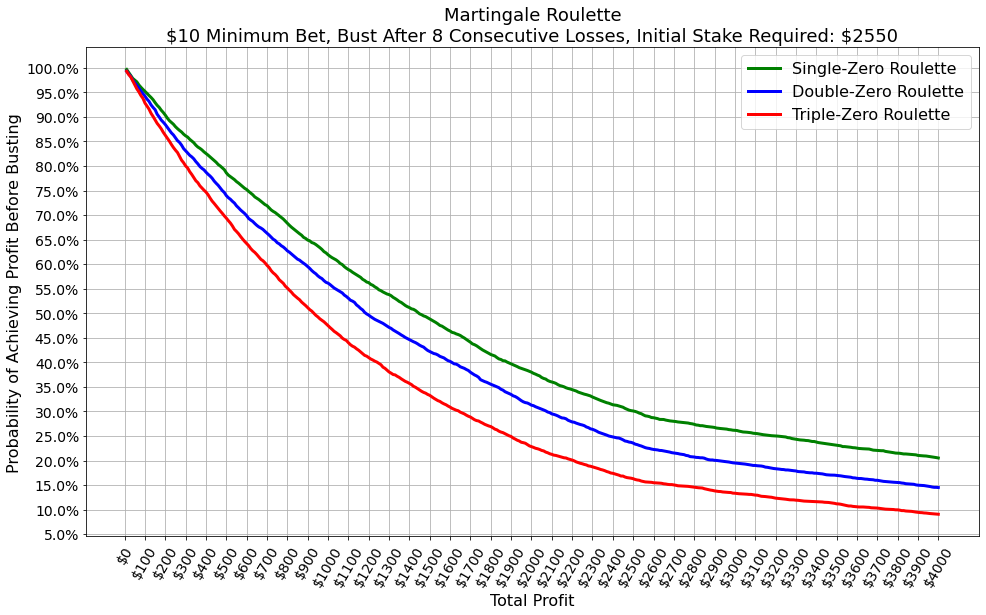

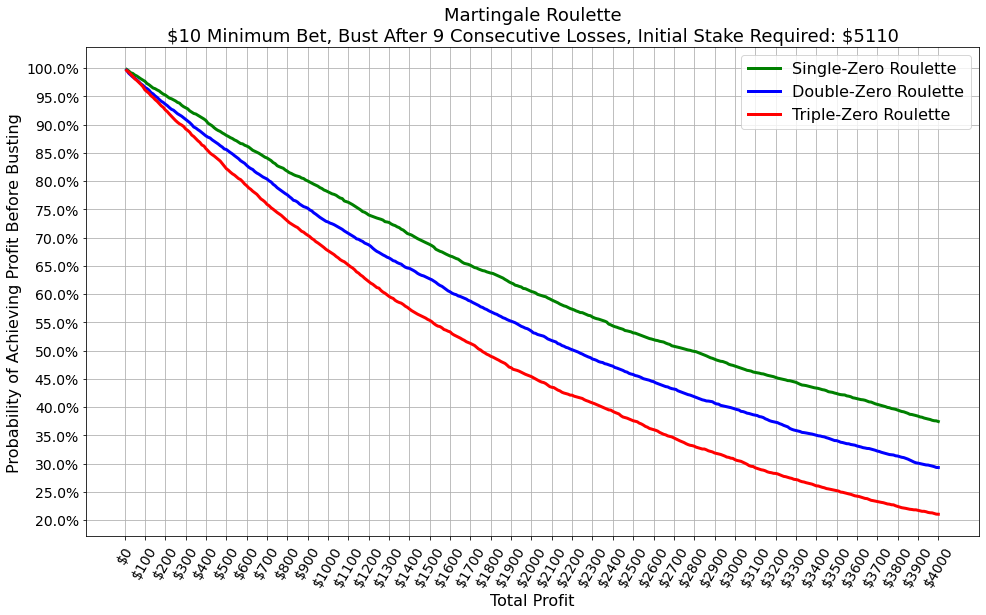



Processing complete! All results saved to "results.zip".


In [ ]:
#create a dataframe to hold the numerical results
df = pd.DataFrame(columns=['minimum_bet', 'consecutive_losses_until_bust',
                           'required_initial_stake', 'number_of_zeros_on_wheel','target_profit',
                           'probability_of_achieving_profit_before_busting'])

#create a list to hold the names of all of the results files
filenames = []

#simulate playing roulette under a variety of conditions
zeros = [1, 2, 3]
for minimum_bet in [3, 5, 10]:
  for consecutive_losses_until_bust in range(5, 9):
    all_results, plt = play_roulette(minimum_bet, consecutive_losses_until_bust, zeros)
    #append the numerical results for the current playing conditions to the dataframe
    for current_results in all_results:
      df = df.append(current_results, ignore_index=True)
    #save and display a graphical plot of the results for the current playing conditions
    filenames.append('min_bet {} losses {}.png'.format(minimum_bet, consecutive_losses_until_bust))
    plt.savefig(filenames[-1])
    plt.show()
    print('\n')

#save the numerical results to an Excel spreadsheet
filenames.append('results.xlsx')
df.to_excel(filenames[-1], index=False)

#add all of the results files to a single ZIP file and cleanup the folder
#by deleting all of the individual results files
with ZipFile('results.zip', 'w') as zip:
  for filename in filenames:
    zip.write(filename)
    os.remove(filename)

#processing complete!
print('Processing complete! All results saved to "results.zip".')